In [47]:
# used to handle data
import pandas as pd

# used to handle geo data
from shapely.ops import transform, Point
from geopandas.tools import reverse_geocode
import geopandas as gpd

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# Plotting library
from matplotlib import pyplot as plt

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import sys
sys.path.append('./')




read AIRBNB data

In [48]:
data = pd.read_csv('BigML_Dataset_5dd97775fb7bdd184c00024f.csv')
data.head()

id                            listing_url       scrape_id  \
0   9784567   https://www.airbnb.com/rooms/9784567  20160704013910   
1  13163805  https://www.airbnb.com/rooms/13163805  20160704013910   
2   3719167   https://www.airbnb.com/rooms/3719167  20160704013910   
3  13188367  https://www.airbnb.com/rooms/13188367  20160704013910   
4   4831606   https://www.airbnb.com/rooms/4831606  20160704013910   

  last_scraped                                               name  \
0   2016-07-04                             nice Room in Amsterdam   
1   2016-07-04        Best cost benefit room near a metro station   
2   2016-07-04  Nice  room in A´dam SE near nature & heart centre   
3   2016-07-04     Private room 15min metro ride from city center   
4   2016-07-04    Room in Amsterdam in a new house!! Free Bicycle   

                                             summary  \
0  nice Room 20 Min.to Amst.center 10 minutes wal...   
1  We (me and my wife) are constantly improving o...   
2  I offer a beautiful 19 sqm room in a house on ...   
3  The apartment is located a 15min ride from the...   
4  In Amsterdam Zuidoost (20 minutes to central s...   

                                               space  \
0                                                NaN   
1                                                NaN   
2  The location is close to the shops, public tra...   
3                                                NaN   
4                                           Smart tv   

                                         description experiences_offered  \
0  nice Room 20 Min.to Amst.center 10 minutes wal...                none   
1  We (me and my wife) are constantly improving o...                none   
2  I offer a beautiful 19 sqm room in a house on ...                none   
3  The apartment is located a 15min ride from the...                none   
4  In Amsterdam Zuidoost (20 minutes to central s...                none   

                               neighborhood_overview  ...  \
0              nice Park metro in front bus in front  ...   
1                                                NaN  ...   
2  A lot of different internationalities and cult...  ...   
3                                                NaN  ...   
4                                                NaN  ...   

  calendar_last_scraped.day-of-month calendar_last_scraped.day-of-week  \
0                                  4                                 1   
1                                  4                                 1   
2                                  4                                 1   
3                                  4                                 1   
4                                  4                                 1   

  first_review.year first_review.month first_review.day-of-month  \
0            2016.0                1.0                       2.0   
1            2016.0                6.0                      13.0   
2            2014.0                8.0                      17.0   
3            2016.0                5.0                      29.0   
4            2015.0                1.0                       2.0   

  first_review.day-of-week last_review.year last_review.month  \
0                      6.0           2016.0               6.0   
1                      1.0           2016.0               6.0   
2                      7.0           2016.0               1.0   
3                      7.0           2016.0               5.0   
4                      5.0           2016.0               3.0   

  last_review.day-of-month  last_review.day-of-week  
0                     27.0                      1.0  
1                     27.0                      1.0  
2                      2.0                      6.0  
3                     31.0                      2.0  
4                     22.0                      2.0  

[5 rows x 115 columns]

## ''cleaning' the data


In [49]:
# we want to use only numeric data for the linear regression
numeric_data = data.select_dtypes(exclude=['object'])

remove data that seems irrelevant for pricing

In [50]:
# remove unrelevant features
relevant_data = numeric_data.drop(columns=['id','scrape_id','host_id',
                                           'last_scraped.year','last_scraped.month','last_scraped.day-of-month',
                                           'last_scraped.day-of-week','host_since.month','host_since.year'
                                           ,'host_since.day-of-month','host_since.day-of-week','calendar_last_scraped.year'
                                           ,'calendar_last_scraped.month','calendar_last_scraped.day-of-month','calendar_last_scraped.day-of-week'
                                           ,'last_review.year','last_review.month','last_review.day-of-month','last_review.day-of-week'
                                           ,'first_review.year'])
                                           # ,'first_review.month','first_review.day-of-month','first_review.day-of-week'
                                           # ,'last_review.month','availability_30','availability_60','availability_90','availability_365',])

del numeric_data

removing rows and columns that contains significant amount of nans

In [51]:
relevant_data.dropna(axis='columns', thresh= data.shape[0]*0.8, inplace=True)
relevant_data.dropna(axis='index', inplace=True)


choose training data and testing data randomly

In [52]:
# we randomly choose 80% of the data to train the model with
train_data = relevant_data.sample(frac = 0.8)

# taking out from the dataframe the price because it is the feature we try to predict
y_train = train_data['price'].values
train_data = train_data.drop(columns='price')

In [53]:
# the test data is the remaining 20% of the data
test_data = relevant_data.loc[relevant_data.index.difference(train_data.index)]
y_test = test_data['price'].values
test_data = test_data.drop(columns='price')

create feature normalize function

In [54]:
# function for normalize values
def featureNormalize(X):
    """
    Normalizes the features in X. returns a normalized version of X where
    the mean value of each feature is 0 and the standard deviation
    is 1. This is often a good preprocessing step to do when working with
    learning algorithms.

    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n).

    Returns
    -------
    X_norm : array_like
        The normalized dataset of shape (m x n).

    """
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    n = (X.shape[0])
    mu = np.average(X, 0)
    mat1 = np.dot(mu.T[:, None], np.ones([1, n])).T
    X_norm = X_norm - mat1

    sigma = np.std(X, 0)
    mat2 = np.dot(sigma.T[:, None], np.ones([1, n])).T
    X_norm = X_norm / mat2

    return X_norm, mu, sigma

normalize values for visualization

In [55]:
values = test_data.values
norm_values, mean, sigma = featureNormalize(values)

normalized_training_data = pd.DataFrame(norm_values, index=test_data.index, columns=test_data.columns)
normalized_training_data.head()

host_response_rate  host_acceptance_rate  host_listings_count  \
0             0.447405              0.650205            -0.136638   
4             0.447405             -1.170714            -0.233625   
11            0.447405              0.480817            -0.233625   
15            0.447405              0.650205            -0.136638   
26            0.447405              0.650205            -0.136638   

    host_total_listings_count  latitude  longitude  accommodates  bathrooms  \
0                   -0.136638 -2.755896   2.695387     -0.649797  -0.339076   
4                   -0.233625 -2.505347   2.382136     -1.311345  -0.339076   
11                  -0.233625 -2.803114   2.180223     -0.649797  -0.339076   
15                  -0.136638 -3.126374   2.926357     -0.649797   2.387779   
26                  -0.136638 -2.820329   2.547741     -0.649797  -0.339076   

    bedrooms      beds  ...  review_scores_cleanliness  review_scores_checkin  \
0   -0.46755  0.046585  ...                  -0.326628              -0.830835   
4   -0.46755 -0.628892  ...                  -0.326628               0.498779   
11  -0.46755 -0.628892  ...                  -3.500059              -0.830835   
15  -0.46755 -0.628892  ...                   0.731182               0.498779   
26  -0.46755 -0.628892  ...                  -0.326628              -0.830835   

    review_scores_communication  review_scores_location  review_scores_value  \
0                      0.428574               -1.786602            -1.186433   
4                      0.428574               -1.786602            -0.046457   
11                     0.428574               -1.786602            -1.186433   
15                     0.428574               -0.463756             1.093520   
26                     0.428574               -1.786602            -1.186433   

    calculated_host_listings_count  reviews_per_month  first_review.month  \
0                        -0.123973          -0.537412           -1.633425   
4                        -0.227342          -0.648075           -1.633425   
11                       -0.227342          -0.627325            0.344876   
15                       -0.123973           2.671816           -1.303708   
26                       -0.123973           0.064319            0.015159   

    first_review.day-of-month  first_review.day-of-week  
0                   -1.446326                  0.998713  
4                   -1.446326                  0.574116  
11                   0.084856                  0.149519  
15                  -0.243254                  0.998713  
26                   1.178558                  0.574116  

[5 rows x 31 columns]

visualize the data

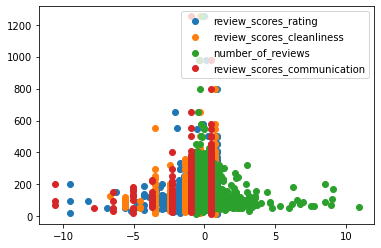

In [56]:
plt.figure()

ax = plt.scatter(normalized_training_data['review_scores_rating'].values, y_test, label= 'review_scores_rating')
plt.scatter(normalized_training_data['review_scores_cleanliness'].values, y_test, label= 'review_scores_cleanliness')
plt.scatter(normalized_training_data['number_of_reviews'].values, y_test, label= 'number_of_reviews')
plt.scatter(normalized_training_data['review_scores_communication'].values, y_test, label= 'review_scores_communication')

plt.legend()
plt.show()

compute cost and gradient decent functions

In [57]:
def computeCost(X, y, theta):
    """
    Compute cost for linear regression. Computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1), where m is the number of examples,
        and n is the number of features. We assume a vector of one's already
        appended to the features so we have n+1 columns.

    y : array_like
        The values of the function at each data point. This is a vector of
        shape (m, ).

    theta : array_like
        The parameters for the regression function. This is a vector of
        shape (n+1, ).

    Returns
    -------
    J : float
        The value of the regression cost function.

    Instructions
    ------------
    Compute the cost of a particular choice of theta.
    You should set J to the cost.
    """

    # initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly
    J = 0

    # ====================== YOUR CODE HERE =====================
    J = 1/(2*m)*np.dot((np.dot(X,theta) - y).T,(np.dot(X,theta) - y))

    # ===========================================================
    return J

def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).

    y : arra_like
        Value at given features. A vector of shape (m, ).

    theta : array_like
        Initial values for the linear regression parameters.
        A vector of shape (n+1, ).

    alpha : float
        The learning rate.

    num_iters : int
        The number of iterations for gradient descent.

    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).

    J_history : list
        A python list for the values of the cost function after each iteration.

    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0]  # number of training examples

    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()

    J_history = [] # Use a python list to save cost in every iteration

    for i in range(num_iters):
        # ==================== YOUR CODE HERE =================================

        theta = theta - (alpha/m)*np.dot(X.T,(np.dot(X,theta)-y))
        # =====================================================================

        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))

    return theta, J_history




In [58]:
values = train_data.values
norm_values, mean, sigma = featureNormalize(values)

normalized_data = pd.DataFrame(norm_values, index=train_data.index, columns=train_data.columns)
normalized_data.head()


host_response_rate  host_acceptance_rate  host_listings_count  \
12136            0.444583              0.645860            -0.198739   
1644             0.444583              0.645860             5.700202   
11952            0.444583              0.645860            -0.153709   
12557           -0.342381             -0.981406            -0.243769   
1816             0.444583              0.645860            -0.243769   

       host_total_listings_count  latitude  longitude  accommodates  \
12136                  -0.198739 -0.433662  -0.780568     -0.671762   
1644                    5.700202  0.747619   0.081142      0.665475   
11952                  -0.153709 -0.574727  -0.912456      0.665475   
12557                  -0.243769  0.645655  -1.193394     -0.671762   
1816                   -0.243769  0.758102  -0.188083     -0.671762   

       bathrooms  bedrooms      beds  ...  review_scores_cleanliness  \
12136  -0.346615  0.699312 -0.632135  ...                  -1.505587   
1644   -0.346615 -0.449504  0.048633  ...                  -0.406714   
11952   4.118941  0.699312  0.729400  ...                   0.692160   
12557  -0.346615 -0.449504 -0.632135  ...                   0.692160   
1816   -0.346615 -0.449504 -0.632135  ...                  -0.406714   

       review_scores_checkin  review_scores_communication  \
12136              -0.913048                    -1.072280   
1644               -0.913048                    -1.072280   
11952               0.477130                     0.443122   
12557              -0.913048                     0.443122   
1816                0.477130                     0.443122   

       review_scores_location  review_scores_value  \
12136                0.822498            -0.090519   
1644                 0.822498            -1.269265   
11952                0.822498             1.088227   
12557               -0.486830            -0.090519   
1816                 0.822498             1.088227   

       calculated_host_listings_count  reviews_per_month  first_review.month  \
12136                       -0.187550          -0.496165            1.018458   
1644                         5.890341           0.401053           -1.290986   
11952                       -0.139313          -0.413978            0.028696   
12557                       -0.235787          -0.208508           -1.620907   
1816                        -0.235787           1.421554           -0.961065   

       first_review.day-of-month  first_review.day-of-week  
12136                  -1.539637                 -0.708775  
1644                   -1.106517                  0.577367  
11952                   1.275647                 -1.137489  
12557                  -1.431357                  1.006081  
1816                   -0.240275                  1.434795  

[5 rows x 31 columns]

In [59]:
m = train_data.shape[0]
# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), normalized_data], axis=1)

building linear regression model

In [60]:
# Choose some alpha value - change this
alpha = 0.1
num_iters = 400

# init theta and run gradient descent
theta = np.zeros(X.shape[1])
theta, J_history = gradientDescent(X, y_train, theta, alpha, num_iters)

Text(0, 0.5, 'Cost J')

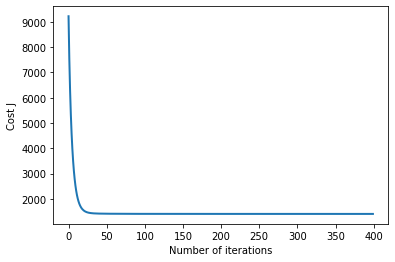

In [61]:
# Plot the convergence graph
plt.plot(np.arange(len(J_history)), J_history, lw=2)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

normalize the test data

In [62]:
values = test_data.values
# norm_values, mean, sigma = featureNormalize(values)
norm_values = (values - mean)/sigma

normalized_data = pd.DataFrame(norm_values, index=test_data.index, columns=test_data.columns)
normalized_data.head()

host_response_rate  host_acceptance_rate  host_listings_count  \
0             0.444583              0.645860            -0.153709   
4             0.444583             -1.245286            -0.243769   
11            0.444583              0.469939            -0.243769   
15            0.444583              0.645860            -0.153709   
26            0.444583              0.645860            -0.153709   

    host_total_listings_count  latitude  longitude  accommodates  bathrooms  \
0                   -0.153709 -2.821909   2.700011     -0.671762  -0.346615   
4                   -0.243769 -2.562551   2.387274     -1.340380  -0.346615   
11                  -0.243769 -2.870786   2.185693     -0.671762  -0.346615   
15                  -0.153709 -3.205410   2.930601     -0.671762   2.630422   
26                  -0.153709 -2.888606   2.552607     -0.671762  -0.346615   

    bedrooms      beds  ...  review_scores_cleanliness  review_scores_checkin  \
0  -0.449504  0.048633  ...                  -0.406714              -0.913048   
4  -0.449504 -0.632135  ...                  -0.406714               0.477130   
11 -0.449504 -0.632135  ...                  -3.703333              -0.913048   
15 -0.449504 -0.632135  ...                   0.692160               0.477130   
26 -0.449504 -0.632135  ...                  -0.406714              -0.913048   

    review_scores_communication  review_scores_location  review_scores_value  \
0                      0.443122               -1.796159            -1.269265   
4                      0.443122               -1.796159            -0.090519   
11                     0.443122               -1.796159            -1.269265   
15                     0.443122               -0.486830             1.088227   
26                     0.443122               -1.796159            -1.269265   

    calculated_host_listings_count  reviews_per_month  first_review.month  \
0                        -0.139313          -0.544108           -1.620907   
4                        -0.235787          -0.653692           -1.620907   
11                       -0.235787          -0.633145            0.358617   
15                       -0.139313           2.633827           -1.290986   
26                       -0.139313           0.051754            0.028696   

    first_review.day-of-month  first_review.day-of-week  
0                   -1.431357                  1.006081  
4                   -1.431357                  0.577367  
11                   0.084565                  0.148653  
15                  -0.240275                  1.006081  
26                   1.167367                  0.577367  

[5 rows x 31 columns]

In [63]:
m = test_data.shape[0]
# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), normalized_data], axis=1)

testing the model

In [64]:
predicted_price = np.dot(X, theta)

diff_from_truth = np.abs(y_test - predicted_price)
success_condition = 50 # dollar per night
success_rate = (np.sum(diff_from_truth < 50) * 100) / diff_from_truth.size
print('success rate for difference up to 50$ is: ', success_rate,'%')


success rate for difference up to 50$ is:  78.21316614420063 %


## classify cheap or expensive listing using logistic regression ML

 prepering the data we need for this part

In [65]:
relevant_data = data[['latitude', 'longitude', 'room_type', 'price', 'name']]

del data

 we chose dam square to be Amsterdam's center 

In [66]:
city_center = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
city_center['geometry'] = [Point(52.373204, 4.892694)]
# transform to metric grid
city_center = city_center.to_crs({'init': 'epsg:23095'})

 measure distance from city center

In [67]:
# create point objects from listing's coordinates and measure distance ftom city cenetr
geometry = []
distance_from_city_center =[]
for index, row in relevant_data.iterrows() :
    p = Point(row['latitude'], row['longitude'])
    geometry.append(p)

relevant_data['geometry'] = geometry

relevant_data = gpd.GeoDataFrame(relevant_data, geometry='geometry', crs={'init': 'epsg:4326'})
relevant_data = relevant_data.to_crs({'init': 'epsg:23095'})

distance_from_city_center =  relevant_data.apply(lambda row: row['geometry'].distance(city_center['geometry'][0]), axis=1)
relevant_data['distance_from_city_center'] = distance_from_city_center
relevant_data.head()



latitude  longitude     room_type  price  \
0  52.323369   4.977730  Private room     95   
1  52.315635   4.978166  Private room     60   
2  52.316711   4.986618  Private room     45   
3  52.321204   4.976630  Private room     35   
4  52.327270   4.967352  Private room     39   

                                                name  \
0                             nice Room in Amsterdam   
1        Best cost benefit room near a metro station   
2  Nice  room in A´dam SE near nature & heart centre   
3     Private room 15min metro ride from city center   
4    Room in Amsterdam in a new house!! Free Bicycle   

                         geometry  distance_from_city_center  
0  POINT (6461477.837 812669.679)               16084.631270  
1  POINT (6460212.748 812621.129)               16818.796770  
2  POINT (6460257.534 814008.759)               17885.806567  
3  POINT (6461142.494 812457.831)               16114.003641  
4  POINT (6462272.258 811045.944)               14306.384975

In [68]:
# print(relevant_data['room_type'])

In [69]:
# 'shared room' has too little examples so we decided to divide it to 'home/apt' or not
# we want room type to be 1 for 'home/apt' else 0
room_type = relevant_data['room_type'] == 'Entire home/apt'
relevant_data['home/apt'] = room_type
relevant_data.head()

latitude  longitude     room_type  price  \
0  52.323369   4.977730  Private room     95   
1  52.315635   4.978166  Private room     60   
2  52.316711   4.986618  Private room     45   
3  52.321204   4.976630  Private room     35   
4  52.327270   4.967352  Private room     39   

                                                name  \
0                             nice Room in Amsterdam   
1        Best cost benefit room near a metro station   
2  Nice  room in A´dam SE near nature & heart centre   
3     Private room 15min metro ride from city center   
4    Room in Amsterdam in a new house!! Free Bicycle   

                         geometry  distance_from_city_center  home/apt  
0  POINT (6461477.837 812669.679)               16084.631270     False  
1  POINT (6460212.748 812621.129)               16818.796770     False  
2  POINT (6460257.534 814008.759)               17885.806567     False  
3  POINT (6461142.494 812457.831)               16114.003641     False  
4  POINT (6462272.258 811045.944)               14306.384975     False

 create cheap\expensive feature

In [70]:
expensive_condition = 100
expensive = relevant_data['price'] > 100
relevant_data['expensive'] = expensive

# relevant_data = relevant_data[['distance_from_city_center','home/apt', 'expensive']]

relevant_data.head()

latitude  longitude     room_type  price  \
0  52.323369   4.977730  Private room     95   
1  52.315635   4.978166  Private room     60   
2  52.316711   4.986618  Private room     45   
3  52.321204   4.976630  Private room     35   
4  52.327270   4.967352  Private room     39   

                                                name  \
0                             nice Room in Amsterdam   
1        Best cost benefit room near a metro station   
2  Nice  room in A´dam SE near nature & heart centre   
3     Private room 15min metro ride from city center   
4    Room in Amsterdam in a new house!! Free Bicycle   

                         geometry  distance_from_city_center  home/apt  \
0  POINT (6461477.837 812669.679)               16084.631270     False   
1  POINT (6460212.748 812621.129)               16818.796770     False   
2  POINT (6460257.534 814008.759)               17885.806567     False   
3  POINT (6461142.494 812457.831)               16114.003641     False   
4  POINT (6462272.258 811045.944)               14306.384975     False   

   expensive  
0      False  
1      False  
2      False  
3      False  
4      False

 cost function and optimization

In [71]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.

    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector
        or a 2-D matrix.

    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.

    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)

    # You need to return the following variables correctly
    g = np.zeros(z.shape)

    mat1 = np.ones(z.shape)
    g = mat1/(mat1 + np.exp(-z))

    return g

def costFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    J : float
        The computed value for the cost function.

    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.

    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    J = 0
    grad = np.zeros(theta.shape)

    J = (1/m) * ((np.dot((-1*y).T,np.log(sigmoid(np.dot(X,theta))))) - (np.dot((1-y).T,np.log(1-sigmoid(np.dot(X,theta))))))
    grad = (1/m) * np.dot(X.T,(sigmoid(np.dot(X,theta))-y))

    # =============================================================
    return J, grad





 visualize the data

In [72]:
def plotData(X, y):
    """
    Plots the data points X and y into a new figure. Plots the data
    points with * for the positive examples and o for the negative examples.

    Parameters
    ----------
    X : array_like
        An Mx2 matrix representing the dataset.

    y : array_like
        Label values for the dataset. A vector of size (M, ).

    Instructions
    ------------
    Plot the positive and negative examples on a 2D plot, using the
    option 'k*' for the positive examples and 'ko' for the negative examples.
    """
    # Create New Figure
    fig = plt.figure()

    # ====================== YOUR CODE HERE ======================
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    plt.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    plt.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)


In [73]:
# remove outliers
relevant_data = relevant_data[relevant_data['price'] < 4000]

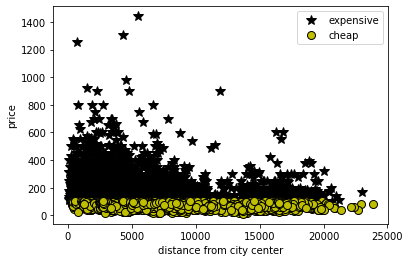

In [74]:
plotData(relevant_data[['distance_from_city_center','price']].values,relevant_data['expensive'].values)
# plt.scatter(relevant_data['distance_from_city_center'].values,data['price'].values)
# add axes labels
plt.xlabel('distance from city center')
plt.ylabel('price')
plt.legend(['expensive', 'cheap'])


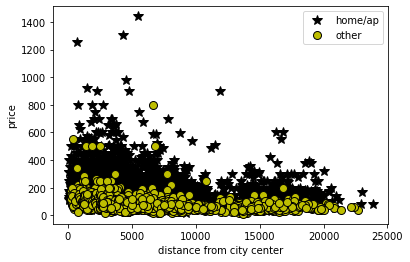

In [75]:
plotData(relevant_data[['distance_from_city_center','price']].values,relevant_data['home/apt'].values)
# plt.scatter(relevant_data['distance_from_city_center'].values,data['price'].values)
# add axes labels
plt.xlabel('distance from city center')
plt.ylabel('price')
plt.legend(['home/ap', 'other'])


In [76]:
X = np.vstack([relevant_data['distance_from_city_center'].values,relevant_data['home/apt'].values]).T
y = relevant_data['expensive'].values

 choosing train and test data


map feature

In [77]:

X = utils.mapFeature(X[:, 0], X[:, 1])
X = X[:,1:]

In [78]:
# print(np.sum(X[:,1]))

 normalize the data

In [79]:
norm_X, mean, sigma = featureNormalize(X)

 concatenate X


In [80]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), norm_X], axis=1)


In [81]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)

    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).

    X : array_like
        The data to use for computing predictions. The rows is the number
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X.

    Instructions
    ------------
    Complete the following code to make predictions using your learned
    logistic regression parameters.You should set p to a vector of 0's and 1's
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    p = sigmoid(np.dot(X,theta)) >= 0.5

    # ============================================================
    return p


In [82]:
# Initialize fitting parameters
initial_theta = np.zeros(n+1)

# set options for optimize.minimize
options= {'maxiter': 400}

res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))





Cost at theta found by optimize.minimize: 0.542
theta:
	[0.276, -3.121, 0.190]


 predict and success rate


In [83]:
#  Predict probability for 'shared room' or 'private room' 3km from city center to be expensive

x = np.array([ 3000, 0])
x = utils.mapFeature(x[0], x[1])
x = x[1:]
x = (x - mean)/sigma
# Add intercept term to X
x = np.hstack([1,x])
prob = sigmoid(np.dot(x, theta))
print('For a shared room or private room 3km from city center,'
      'we predict probability of {:.3f} to be expensive'.format(prob))
print('or probability of {:.3f} to be cheap'.format(1-prob))

#  Predict probability for 'home\apt' 3km from city center to be expensive

x = np.array([ 3000, 1])
x = utils.mapFeature(x[0], x[1])
x = x[1:]
x = (x - mean)/sigma
# Add intercept term to X
x = np.hstack([1,x])
prob = sigmoid(np.dot(x, theta))
print('For a home\\apt 3km from city center,'
      'we predict probability of {:.3f} to be expensive,'.format(prob))


# Compute accuracy on our training set
p = predict(theta, X)
print('\nTrain Accuracy of model is: {:.2f} %'.format(np.mean(p == y) * 100))



For a shared room or private room 3km from city center,we predict probability of 0.215 to be expensive
or probability of 0.785 to be cheap
For a home\apt 3km from city center,we predict probability of 0.792 to be expensive,

Train Accuracy of model is: 71.30 %


we can't realy locate expensive or less expensive area
just by using distance from city center. to do so we will have to use
the listings coordinates, or by changing the "city center" to different parts of the city.

we can determine that listings who are closer to Dam square have higher
probability to be expensive.



In [84]:
X = np.vstack([relevant_data['distance_from_city_center'].values,relevant_data['home/apt'].values]).T
# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), norm_X], axis=1)
y = expensive
# Plot Boundary
# utils.plotDecisionBoundary(plotData, theta, X, y)

## part 6 - Graphic Results

In [98]:
import folium

In [99]:
a = folium.Map(location=[52.373204, 4.892694])

In [100]:
tooltip = 'Click me!'
# folium.Circle(
#     radius=20,
#     location=[52.373204, 4.892694],
#     popup='Dam Square',
#     color='crimson',
#     fill=False,
# ).add_to(a)
folium.Marker([52.373204, 4.892694], popup='<b>Dam Square</b>', tooltip=tooltip).add_to(a)


In [101]:
draw_data = relevant_data.sample(frac = 0.2)

In [102]:
# del relevant_data, x, y, y_test, y_train, values, train_data, geometry, expensive, distance_from_city_center

In [103]:
# I can add marker one by one on the map
for i in range(0,len(draw_data)):
    if draw_data.iloc[i]['expensive']:
       folium.Circle(
          location=[draw_data.iloc[i]['latitude'], draw_data.iloc[i]['longitude']],
          popup=draw_data.iloc[i]['name'],
          radius=draw_data.iloc[i]['price']/10,
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(a)
    else:
        folium.Circle(
          location=[draw_data.iloc[i]['latitude'], draw_data.iloc[i]['longitude']],
          popup=draw_data.iloc[i]['name'],
          radius=draw_data.iloc[i]['price']/10,
          color='green',
          fill=True,
          fill_color='crimson'
       ).add_to(a)

the bigger the circle, the higher the price
green circles are cheap listings and red are expensive.

In [104]:
a

### Summary and Conclusions

we had data of 13,850 listings םכ AIRBNB in Amsterdam.
from that data we built two models:
1. model for predicting price of listing - linear regression
2. model for classification if a listing is expensive - logistic regression

for the first model we had to analyze the data and pick features
that we thought would contribute to the prediction. We chose to use only numeric
features to reduce complications, and we decided to use as many numeric features
as possible.
Success rate of this model is about 78%, when you consider 50$ difference as success.
We think it's pretty poor results. we could probably got better results if we used some of the text features.

for the second model we had to determine the probability of a listing to be expensive
considering it's distance from city center and it's type.
Success rate of this model is about 71.5%.
Results again are pretty poor. We can determine with some confidence that listings who are closer to city center has higher probability to be expensive.
For better classification we have to consider more features.

In [105]:
a.save('amsterdam_AirBNB.html')